<a href="https://colab.research.google.com/github/Masioki/GAN-Text-Generator/blob/main/Text_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**GAN based random text generator**

GAN is well known for it's non-discrete data generation abilities.<br>
In this notebook I'll adapt and train GAN for text generation(based on [LaText GAN](https://arxiv.org/pdf/1810.06640.pdf)). 

First, let's create data loader with tokenizer.

In [16]:
import re
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer


class DataLoader:

    def __init__(self, src_csv="", src_column='', sentence_len=100, num_words=10000):
        self.__src_csv = src_csv  # source csv file with test data
        self.__src_column = src_column # column name in source file
        self.__sentence_len = sentence_len  # max sentence length
        self.__num_words = num_words  # number of most frequent words to keep
        self.__tokenizer = None # tokenizer
        self.sentences = []  # text data
        self.sequences = np.array([])  # indexed data from tokenizer

    def __load_file(self):
        df = pd.read_csv(self.__src_csv, keep_default_na=False) 
        self.sentences = [re.sub(r"<.*?>", " ", x) for x in df['review']]  # remove html tags
        self.sentences = [s.replace('.', ' .') for s in self.sentences] # let's keep period
        self.sentences = [ ' '.join(s.split(' ')[:int(self.__sentence_len * 1.2)])  for s in self.sentences]
        # rest of data cleaning is done by tokenizer

    def __init_tokenizer(self):
        # Tokenization
        # splitted by space
        # filters = default - period sign
        # unknown word set to <OOV>
        # lower case
        # saves only __num_words most frequent words
        self.tokenizer = Tokenizer(num_words=self.__num_words, lower=True, split=' ', oov_token='<OOV>', filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
        self.tokenizer.fit_on_texts(self.sentences) # fit on text data
        
    def __init_sequences(self):
        if self.sequences.size < 1:
            self.__load_file()
            self.__init_tokenizer()
            self.sequences = self.tokenizer.texts_to_sequences(self.sentences) # text to tokenizer indexes
            self.sequences = pad_sequences(self.sequences, maxlen=self.__sentence_len, dtype='float32', padding='post') # padding 
            

    def get(self):
        self.__init_sequences()
        return self.sequences

Define all parameters and paths.

In [3]:
SOURCE_FILE = "drive/MyDrive/Colab Notebooks/IMDB Dataset.csv" # test data file path (here IMDB reviews)
AE_MODEL_PATH="drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2" # autoencoder path
PLOT_PATH="drive/MyDrive/Colab Notebooks/plots/{}2.png" # plots path
HISTORY_PATH="drive/MyDrive/Colab Notebooks/history/{}2.csv" # learning history path
EMBEDDING_PATH="drive/MyDrive/Colab Notebooks/model.txt" # path to prepared word embedding
EMBEDDING_MATRIX_PATH="embedding_matrix.npy" # path to embedding matrix

MAX_WORD_NUM = 4500 # max number of most frequent words to save
MAX_SEQUENCE_LEN = 20 # max sentence length
ENCODED_VECTOR_LEN = 300 # enoded sentence length
EMBEDDING_SIZE = 300 # embedding vector length

Load our data.

In [17]:
dataLoader = DataLoader(SOURCE_FILE, sentence_len=MAX_SEQUENCE_LEN, num_words=MAX_WORD_NUM)
data = dataLoader.get()

np.random.seed(2137)
np.random.shuffle(data) 

data.shape

(50000, 20)

Now, we need to create embedding matrix (saved in EMBEDDING_MATRIX_PATH). To do this already trained word embedding model is necessary. Embedding matrix will keep vectors for words from vocabulary/tokenizer.



Word embedding model is meant to represent complex relationships between words (i.e. 'female', 'girl', 'woman' - similar concept, but completly different spelling) by placing each word in some N dimensional space.

Here I use 300 dimensional model only for english.


In [5]:
# read word embedding model
# each line consist of word and X normalized values
embeddings_index = {}
f = open(EMBEDDING_PATH, 'r')
for line in f:
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
    except ValueError:
        continue
    embeddings_index[word] = coefs
f.close()

# build embedding matrix
num_words = min(MAX_WORD_NUM, len(dataLoader.tokenizer.word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_SIZE))
for word, i in dataLoader.tokenizer.word_index.items():
    if i >= MAX_WORD_NUM:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector.astype('float32')   
    else:
        embedding_matrix[i] = np.random.normal(-0.25, 0.25, EMBEDDING_SIZE)

np.save(EMBEDDING_MATRIX_PATH, embedding_matrix) # save matrix
embedding_matrix.shape

(4500, 300)

In case of hardware limitations You might want to use this simple data generator.

Autoencoder(explained below) produces data in one-hot encoding, that's why we need to convert y_train.

Standard encoding:<br>
[0, 3]

one-hot:<br>
[<br>
     &ensp;  [1, 0, 0, 0],<br>
    &ensp;     [0, 0, 0, 1]<br>
]



In [6]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

# if you need to convert sequence to word embedding form
embedding_matrix = np.load(EMBEDDING_MATRIX_PATH) 
def get_embedding(seq):
    return np.array([embedding_matrix[int(w)] for w in seq])

class Mygenerator(Sequence):
    def __init__(self, data, batch_size):
        self.data = data # in/out data
        self.batch_size = batch_size
    
    def on_epoch_end(self): 
        # shuffling each epoch
        np.random.shuffle(self.data) 

    def __len__(self):
        return int(np.ceil(len(self.data) / float(self.batch_size))) # number of batches

    def __getitem__(self, idx):
        batch_x = self.data[idx * self.batch_size:(idx + 1) * self.batch_size] # batch
        x = batch_x
        y = np.array([to_categorical(seq, num_classes=MAX_WORD_NUM) for seq in batch_x]) # y data in one-hot
        return x, y

**AUTOENCODER**

Autoencoder is a pair of two networks - encoder and decoder - connected with 'bottleneck'. Encoder is meant to represent each sequence in compressed form(i.e. 20 seq with 300D embedding requires 6000 values, this encoder will compress it to 300), while decoder decompresses it.

This autoencoder takes whole sequence and outputs whole sequence at once!

<br>
Encoder: <br>
&ensp; input - sequences of indexes from tokenizer<br>
&ensp; output - compressed vector 

<br>
Decoder: <br>
&ensp; input - compressed vector<br>
&ensp; output - sequences of indexes in one-hot encoding



In [7]:
import keras.backend as K
from keras.layers import *
from keras.models import *
from keras.callbacks import ModelCheckpoint

# ENCODER
# 1D input of indexes from tokenizer
inputs = Input(shape=(MAX_SEQUENCE_LEN,), dtype='int32')

# this layer converts indexes to embedding form using prepared embedding_matrix
e = Embedding(MAX_WORD_NUM, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LEN, trainable=False)(inputs)

# stacked LSTM layers
# depending on your parametrs you might want to stack more LSTMs
encoded = Bidirectional(LSTM(ENCODED_VECTOR_LEN, return_sequences=True, name="encoder_bi_lstm"), name="encoder_bi")(e)
# encoder output in form of compressed 1D vector
encoded = LSTM(ENCODED_VECTOR_LEN, name="encoder")(encoded)


# DECODER
# decoder input repeats compressed vector to decode whole sequence
decode_input = RepeatVector(MAX_SEQUENCE_LEN, name="decoder_input")(encoded)

# stacked LSTM layers
decode_input = LSTM(EMBEDDING_SIZE, return_sequences=True, name="decoder_lstm")(decode_input)
decoded = Bidirectional(LSTM(EMBEDDING_SIZE, return_sequences=True, name="decoder_bi_lstm"), name="decoder_bi")(decode_input)

# TimeDistributed allows to apply Dense to each word in sequence
# tests showed that another dense layer is necessary for good validation set accuracy on big vocabulary (92% without on 3250, around 97% with on 4500)
decoded = TimeDistributed(Dense(MAX_WORD_NUM / 2), name="decoder_dense_half")(decoded)

# one-hot encoding mapping
decoded = TimeDistributed(Dense(MAX_WORD_NUM, activation='softmax'), name="decoder")(decoded)

autoencoder = Model(inputs, decoded) 

# categorical crossentropy is great to use with one-hot encoding
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  
autoencoder.summary() 

autoencoder.save(AE_MODEL_PATH) # save untrained model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding (Embedding)       (None, 20, 300)           1350000   
                                                                 
 encoder_bi (Bidirectional)  (None, 20, 600)           1442400   
                                                                 
 encoder (LSTM)              (None, 300)               1081200   
                                                                 
 decoder_input (RepeatVector  (None, 20, 300)          0         
 )                                                               
                                                                 
 decoder_lstm (LSTM)         (None, 20, 300)           721200    
                                                             

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


In [8]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, CSVLogger

# split data
# if you just want to create autoencoder there's no need for validation set
# here I take small batch for validation to see how well autoencoder responds to unseen data, which will be produced by GAN
split_ind = int(len(data) * 0.95) 
data_train = data[:split_ind,:]
data_val = data[split_ind:,:]
print(data_val.shape)

autoencoder = load_model(AE_MODEL_PATH) # load model
autoencoder.summary()

csv_logger = CSVLogger(HISTORY_PATH.format("AE"), append=True) # log history to file
checkpoint = ModelCheckpoint(filepath=AE_MODEL_PATH, save_best_only=True) # save best model for unseen data

# 64 might be optimal
batch_size = 32

# 70 epochs is enough to maximize results
# depending on vocab size, sentence length etc. I achieved
# >99% on training set, 97 % on unseen data from same set
history = autoencoder.fit(x=Mygenerator(data_train, batch_size), epochs=70, validation_data=Mygenerator(data_val, batch_size), callbacks=[checkpoint, csv_logger])

(2500, 20)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding (Embedding)       (None, 20, 300)           1350000   
                                                                 
 encoder_bi (Bidirectional)  (None, 20, 600)           1442400   
                                                                 
 encoder (LSTM)              (None, 300)               1081200   
                                                                 
 decoder_input (RepeatVector  (None, 20, 300)          0         
 )                                                               
                                                                 
 decoder_lstm (LSTM)         (None, 20, 300)           721200    
                                                  

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 195s 123ms/step - loss: 5.3072 - accuracy: 0.1554 - val_loss: 4.1618 - val_accuracy: 0.2825
Epoch 2/70
1485/1485 [==============================] - ETA: 0s - loss: 2.9409 - accuracy: 0.4467

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 179s 121ms/step - loss: 2.9409 - accuracy: 0.4467 - val_loss: 2.0863 - val_accuracy: 0.5621
Epoch 3/70
1485/1485 [==============================] - ETA: 0s - loss: 1.3883 - accuracy: 0.6791

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 179s 121ms/step - loss: 1.3883 - accuracy: 0.6791 - val_loss: 1.0080 - val_accuracy: 0.7500
Epoch 4/70
1485/1485 [==============================] - ETA: 0s - loss: 0.6887 - accuracy: 0.8162

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 182s 122ms/step - loss: 0.6887 - accuracy: 0.8162 - val_loss: 0.6243 - val_accuracy: 0.8347
Epoch 5/70
1485/1485 [==============================] - ETA: 0s - loss: 0.4099 - accuracy: 0.8828

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 182s 123ms/step - loss: 0.4099 - accuracy: 0.8828 - val_loss: 0.4906 - val_accuracy: 0.8675
Epoch 6/70
1485/1485 [==============================] - ETA: 0s - loss: 0.2820 - accuracy: 0.9158

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 181s 122ms/step - loss: 0.2820 - accuracy: 0.9158 - val_loss: 0.4109 - val_accuracy: 0.8911
Epoch 7/70
1485/1485 [==============================] - ETA: 0s - loss: 0.2215 - accuracy: 0.9321

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 180s 121ms/step - loss: 0.2215 - accuracy: 0.9321 - val_loss: 0.3549 - val_accuracy: 0.9051
Epoch 8/70
1485/1485 [==============================] - ETA: 0s - loss: 0.1788 - accuracy: 0.9442

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 180s 121ms/step - loss: 0.1788 - accuracy: 0.9442 - val_loss: 0.3223 - val_accuracy: 0.9161
Epoch 9/70
1485/1485 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.9530

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 179s 121ms/step - loss: 0.1502 - accuracy: 0.9530 - val_loss: 0.2901 - val_accuracy: 0.9249
Epoch 10/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.1307 - accuracy: 0.9586 - val_loss: 0.3128 - val_accuracy: 0.9200
Epoch 11/70
1485/1485 [==============================] - ETA: 0s - loss: 0.1135 - accuracy: 0.9640

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 180s 121ms/step - loss: 0.1135 - accuracy: 0.9640 - val_loss: 0.2868 - val_accuracy: 0.9299
Epoch 12/70
1485/1485 [==============================] - ETA: 0s - loss: 0.1037 - accuracy: 0.9670

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 179s 121ms/step - loss: 0.1037 - accuracy: 0.9670 - val_loss: 0.2738 - val_accuracy: 0.9320
Epoch 13/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0913 - accuracy: 0.9709 - val_loss: 0.2980 - val_accuracy: 0.9274
Epoch 14/70
1485/1485 [==============================] - 137s 92ms/step - loss: 0.0845 - accuracy: 0.9731 - val_loss: 0.2776 - val_accuracy: 0.9334
Epoch 15/70
1485/1485 [==============================] - ETA: 0s - loss: 0.0775 - accuracy: 0.9754

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 182s 123ms/step - loss: 0.0775 - accuracy: 0.9754 - val_loss: 0.2668 - val_accuracy: 0.9378
Epoch 16/70
1485/1485 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9773

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 180s 121ms/step - loss: 0.0714 - accuracy: 0.9773 - val_loss: 0.2666 - val_accuracy: 0.9366
Epoch 17/70
1485/1485 [==============================] - ETA: 0s - loss: 0.0660 - accuracy: 0.9790

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 181s 122ms/step - loss: 0.0660 - accuracy: 0.9790 - val_loss: 0.2330 - val_accuracy: 0.9453
Epoch 18/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0632 - accuracy: 0.9799 - val_loss: 0.2503 - val_accuracy: 0.9426
Epoch 19/70
1485/1485 [==============================] - ETA: 0s - loss: 0.0581 - accuracy: 0.9814

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 181s 122ms/step - loss: 0.0581 - accuracy: 0.9814 - val_loss: 0.2128 - val_accuracy: 0.9501
Epoch 20/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0536 - accuracy: 0.9831 - val_loss: 0.2568 - val_accuracy: 0.9418
Epoch 21/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0530 - accuracy: 0.9831 - val_loss: 0.2254 - val_accuracy: 0.9498
Epoch 22/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0492 - accuracy: 0.9843 - val_loss: 0.2369 - val_accuracy: 0.9470
Epoch 23/70
1485/1485 [==============================] - ETA: 0s - loss: 0.0463 - accuracy: 0.9853

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 178s 120ms/step - loss: 0.0463 - accuracy: 0.9853 - val_loss: 0.2050 - val_accuracy: 0.9531
Epoch 24/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0438 - accuracy: 0.9860 - val_loss: 0.2153 - val_accuracy: 0.9526
Epoch 25/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0427 - accuracy: 0.9864 - val_loss: 0.2209 - val_accuracy: 0.9501
Epoch 26/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0412 - accuracy: 0.9869 - val_loss: 0.2180 - val_accuracy: 0.9517
Epoch 27/70
1485/1485 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9877

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 182s 122ms/step - loss: 0.0391 - accuracy: 0.9877 - val_loss: 0.2020 - val_accuracy: 0.9554
Epoch 28/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0372 - accuracy: 0.9881 - val_loss: 0.2084 - val_accuracy: 0.9550
Epoch 29/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0351 - accuracy: 0.9889 - val_loss: 0.2023 - val_accuracy: 0.9553
Epoch 30/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0352 - accuracy: 0.9889 - val_loss: 0.2055 - val_accuracy: 0.9551
Epoch 31/70
1485/1485 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.9894

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 179s 121ms/step - loss: 0.0337 - accuracy: 0.9894 - val_loss: 0.1984 - val_accuracy: 0.9573
Epoch 32/70
1485/1485 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.9895

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 181s 122ms/step - loss: 0.0330 - accuracy: 0.9895 - val_loss: 0.1921 - val_accuracy: 0.9579
Epoch 33/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0307 - accuracy: 0.9902 - val_loss: 0.1936 - val_accuracy: 0.9584
Epoch 34/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0306 - accuracy: 0.9903 - val_loss: 0.1969 - val_accuracy: 0.9585
Epoch 35/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0298 - accuracy: 0.9906 - val_loss: 0.1968 - val_accuracy: 0.9577
Epoch 36/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0275 - accuracy: 0.9913 - val_loss: 0.1996 - val_accuracy: 0.9582
Epoch 37/70
1485/1485 [==============================] - ETA: 0s - loss: 0.0287 - accuracy: 0.9910

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 182s 123ms/step - loss: 0.0287 - accuracy: 0.9910 - val_loss: 0.1858 - val_accuracy: 0.9610
Epoch 38/70
1485/1485 [==============================] - ETA: 0s - loss: 0.0275 - accuracy: 0.9914

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 181s 122ms/step - loss: 0.0275 - accuracy: 0.9914 - val_loss: 0.1744 - val_accuracy: 0.9615
Epoch 39/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0248 - accuracy: 0.9922 - val_loss: 0.1794 - val_accuracy: 0.9622
Epoch 40/70
1485/1485 [==============================] - 139s 93ms/step - loss: 0.0258 - accuracy: 0.9919 - val_loss: 0.2010 - val_accuracy: 0.9587
Epoch 41/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0250 - accuracy: 0.9921 - val_loss: 0.1948 - val_accuracy: 0.9592
Epoch 42/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0249 - accuracy: 0.9922 - val_loss: 0.1817 - val_accuracy: 0.9637
Epoch 43/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0239 - accuracy: 0.9924 - val_loss: 0.1900 - val_accuracy: 0.9602
Epoch 44/70
1485/1485 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.9928

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 181s 122ms/step - loss: 0.0230 - accuracy: 0.9928 - val_loss: 0.1718 - val_accuracy: 0.9638
Epoch 45/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0225 - accuracy: 0.9930 - val_loss: 0.1786 - val_accuracy: 0.9621
Epoch 46/70
1485/1485 [==============================] - 141s 95ms/step - loss: 0.0215 - accuracy: 0.9932 - val_loss: 0.1804 - val_accuracy: 0.9627
Epoch 47/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0221 - accuracy: 0.9929 - val_loss: 0.1757 - val_accuracy: 0.9645
Epoch 48/70
1485/1485 [==============================] - ETA: 0s - loss: 0.0212 - accuracy: 0.9933

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 180s 122ms/step - loss: 0.0212 - accuracy: 0.9933 - val_loss: 0.1702 - val_accuracy: 0.9644
Epoch 49/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0205 - accuracy: 0.9936 - val_loss: 0.1720 - val_accuracy: 0.9641
Epoch 50/70
1485/1485 [==============================] - ETA: 0s - loss: 0.0201 - accuracy: 0.9936

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 180s 121ms/step - loss: 0.0201 - accuracy: 0.9936 - val_loss: 0.1569 - val_accuracy: 0.9678
Epoch 51/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0199 - accuracy: 0.9938 - val_loss: 0.1843 - val_accuracy: 0.9626
Epoch 52/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0195 - accuracy: 0.9939 - val_loss: 0.1774 - val_accuracy: 0.9625
Epoch 53/70
1485/1485 [==============================] - 139s 93ms/step - loss: 0.0200 - accuracy: 0.9938 - val_loss: 0.1604 - val_accuracy: 0.9665
Epoch 54/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0180 - accuracy: 0.9943 - val_loss: 0.1646 - val_accuracy: 0.9671
Epoch 55/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0182 - accuracy: 0.9943 - val_loss: 0.1579 - val_accuracy: 0.9685
Epoch 56/70
1485/1485 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9942

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 181s 122ms/step - loss: 0.0184 - accuracy: 0.9942 - val_loss: 0.1537 - val_accuracy: 0.9687
Epoch 57/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0171 - accuracy: 0.9946 - val_loss: 0.1631 - val_accuracy: 0.9678
Epoch 58/70
1485/1485 [==============================] - 139s 93ms/step - loss: 0.0172 - accuracy: 0.9946 - val_loss: 0.1656 - val_accuracy: 0.9672
Epoch 59/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0173 - accuracy: 0.9946 - val_loss: 0.1642 - val_accuracy: 0.9669
Epoch 60/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0170 - accuracy: 0.9947 - val_loss: 0.1555 - val_accuracy: 0.9689
Epoch 61/70
1485/1485 [==============================] - 139s 93ms/step - loss: 0.0164 - accuracy: 0.9949 - val_loss: 0.1584 - val_accuracy: 0.9685
Epoch 62/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0161 - accuracy: 0.9950 - val_loss: 0.174

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_4500_cce_dd_2/assets


1485/1485 [==============================] - 178s 120ms/step - loss: 0.0144 - accuracy: 0.9955 - val_loss: 0.1531 - val_accuracy: 0.9694
Epoch 70/70
1485/1485 [==============================] - 138s 93ms/step - loss: 0.0157 - accuracy: 0.9953 - val_loss: 0.1690 - val_accuracy: 0.9676


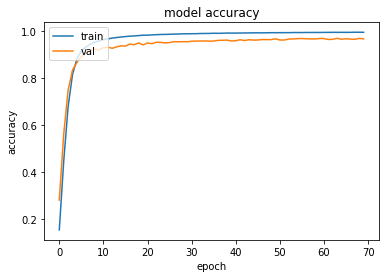

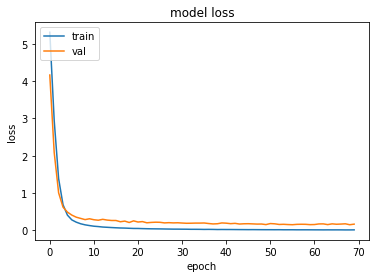

In [9]:
from matplotlib import pyplot as plt

# plot loss and accuracy and save them
def plot_training(loss, val_loss, acc, val_acc):
  plt.plot(acc) 
  plt.plot(val_acc)
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig(PLOT_PATH.format('AE_accuracy'))
  plt.show()

  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig(PLOT_PATH.format('AE_loss'))
  plt.show()

df = pd.read_csv(HISTORY_PATH.format("AE"), keep_default_na=False) 
plot_training(df.iloc[:,2], df.iloc[:,4], df.iloc[:,1], df.iloc[:,3])

As we can see, training data accuracy is fine, but validation accuracy is relatively low (97%).
<br><br>

In GAN training we are mostly interested in generator generating values similar to training set so, if its working well, decoding accuracy of generated samples might be closer to training set accuracy (>99%)
<br>
For purposes of this excercise this is enough.

**Autoencoder test**

In [10]:
from keras import *
import keras.backend as K
from keras.layers import *
from keras.models import load_model

# load model
def load_autoencoder(path):
      model = load_model(path)

      # split into encoder and decoder
      encoder = Model(model.input, model.get_layer('encoder').output)
      decoder = Model(model.get_layer('decoder_input').input, model.get_layer('decoder').output)

      # add Argmax layer to decoder to convert results to real one-hot encoding
      one_hot_to_index = Lambda(lambda x: K.cast(K.argmax(x), dtype='float32'))(decoder.output)
      decoder = Model(decoder.input, one_hot_to_index)
      return (encoder, decoder, model)

(enc, dec, model) = load_autoencoder(AE_MODEL_PATH)

As You can see below, autoencoder works pretty well.<br>
There are some OOV tokens which implies too small vocabulary size.
<br>
Increasing vocabulary impacts learning abilities so we might need to deepen AE architecture.


In [14]:
from tensorflow.keras.utils import to_categorical

# prints input and predicted sentence
def print_test(seq):
    seq = seq.reshape(1, 20)
    predicted = model.predict(seq)
    predicted = np.argmax(predicted, axis=2) # convert one-hot to standard encoding
    
    print("IN SENTENCE         {}".format(' '.join(dataLoader.tokenizer.sequences_to_texts(seq))))
    print("PREDICTED SENTENCE  {}".format(' '.join(dataLoader.tokenizer.sequences_to_texts(predicted))))
    print("----------------------------")

print_test(data[2])
print_test(data[11])
print_test(data[15])
print_test(data[29])
print_test(data[25])
print_test(data[40075])
print_test(data[40055])
print_test(data[49996]) # validation set
print_test(data[49986])

IN SENTENCE         the movie i had a feeling like its a movie about another <OOV> from friday the 13th . and it
PREDICTED SENTENCE  the movie i had a feeling like its a movie about another <OOV> from friday the 13th . and it
----------------------------
IN SENTENCE         joe <OOV> short that i've seen and so far the funniest one . in this one joe takes voice lessons
PREDICTED SENTENCE  joe <OOV> short that i've seen and so far the funniest one . in this one joe takes voice lessons
----------------------------
IN SENTENCE         it really matter have you ever read a movie review <OOV> entirely of questions could this be it why did
PREDICTED SENTENCE  it really matter have you ever read a movie review <OOV> entirely of questions could this be it why did
----------------------------
IN SENTENCE         so many viewers didn't find all the symbolism in the movie . . . . .it's what made the movie
PREDICTED SENTENCE  so many viewers didn't find all the symbolism in the movie . . . . .it's